In [290]:
data_path = "D:/Huge datasets/avito/data"
PAD_LEN_WORD = 35
PAD_LEN_CHAR = 20
N_VECTORS = 80000
EMB_DIM = 300
MAX_VOCAB = 4000
MAX_CHAR = 125

from keras.preprocessing import sequence

In [291]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [292]:
import pandas as pd
import numpy as np
import os

In [293]:
from text_prep import Preparator

In [294]:
pr = Preparator()

In [295]:
train = os.path.join(data_path, "train.csv.zip")
word_vectors_path = os.path.join(data_path, "wiki.ru.vec") # bunch of russian w2v http://rusvectores.org/en/models/

In [297]:
train = pd.read_csv(train,compression="zip",nrows = 700000)
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [8]:
vectors = pr.load_vectors(word_vectors_path, N_VECTORS)

In [298]:
train[["description", "title"]] = train[["description", "title"]].fillna('__NA__')
train["text"] = train.apply(lambda x: x["title"] + " END_DESC " + x["description"], axis=1)

In [317]:
desc = pr.clean_col("text", train)

In [319]:
vocab, char_vocab = pr.create_vocab(desc, MAX_VOCAB , MAX_CHAR)

In [320]:
train_indexed = pr.vocab_lookup(desc ,vocab,  char_vocab)

In [321]:
mat, novect = pr.build_emb(vectors, vocab, EMB_DIM)

2963 words were found over a vocab of 4000 which is a ratio of 0.74


In [322]:
padded_words = sequence.pad_sequences(train_indexed['word_id'], maxlen= PAD_LEN_WORD)
#padded_chars = [sequence.pad_sequences(s, maxlen= PAD_LEN_CHAR) for s in train_indexed['char_id']]

In [305]:
#training params
batch_size = 17 
num_epochs = 32

#model parameters
num_filters = 32 
EMB_DIM = 300 
weight_decay = 1e-7

num_classes = 1

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.pow(y_pred-y_true, 2)))

In [306]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D , GlobalAveragePooling1D, AveragePooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

In [311]:
model = Sequential()
model.add(Embedding(MAX_VOCAB + 1 , EMB_DIM,
          weights=[mat], input_length=PAD_LEN_WORD, trainable=False))
model.add(Dropout(0.5))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(AveragePooling1D(2))
model.add(Conv1D(num_filters - 2, 7, activation='relu', padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_absolute_error', optimizer=adam, metrics=[rmse, "mae"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 35, 300)           1200300   
_________________________________________________________________
dropout_77 (Dropout)         (None, 35, 300)           0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 35, 32)            67232     
_________________________________________________________________
average_pooling1d_16 (Averag (None, 17, 32)            0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 17, 30)            6750      
_________________________________________________________________
global_average_pooling1d_16  (None, 30)                0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 30)                0         
__________

best VAL RMSE loss 0.2845/0.2634

In [312]:
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
#callbacks_list = [early_stopping]
hist = model.fit(padded_words[:100000], np.array(train.deal_probability[:100000]), batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True, verbose=2)

Train on 90000 samples, validate on 10000 samples
Epoch 1/32
 - 99s - loss: 0.1404 - rmse: 0.2870 - mean_absolute_error: 0.1404 - val_loss: 0.1373 - val_rmse: 0.2845 - val_mean_absolute_error: 0.1373
Epoch 2/32
 - 98s - loss: 0.1402 - rmse: 0.2863 - mean_absolute_error: 0.1402 - val_loss: 0.1372 - val_rmse: 0.2847 - val_mean_absolute_error: 0.1372
Epoch 3/32
 - 99s - loss: 0.1402 - rmse: 0.2864 - mean_absolute_error: 0.1402 - val_loss: 0.1372 - val_rmse: 0.2846 - val_mean_absolute_error: 0.1372
Epoch 4/32
 - 103s - loss: 0.1402 - rmse: 0.2865 - mean_absolute_error: 0.1402 - val_loss: 0.1372 - val_rmse: 0.2847 - val_mean_absolute_error: 0.1372
Epoch 5/32
 - 98s - loss: 0.1402 - rmse: 0.2864 - mean_absolute_error: 0.1402 - val_loss: 0.1372 - val_rmse: 0.2847 - val_mean_absolute_error: 0.1372
Epoch 6/32
 - 99s - loss: 0.1402 - rmse: 0.2867 - mean_absolute_error: 0.1402 - val_loss: 0.1372 - val_rmse: 0.2847 - val_mean_absolute_error: 0.1372
Epoch 7/32
 - 97s - loss: 0.1402 - rmse: 0.2867 -

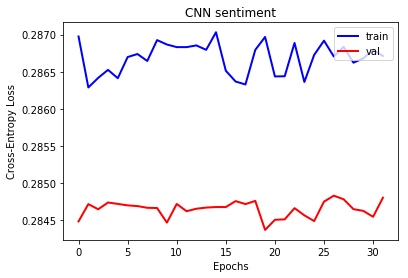

In [324]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist.history['rmse'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_rmse'], lw=2.0, color='r', label='val')
#plt.plot([np.sqrt(h)/15 for h in hist.history["mean_absolute_error"]], lw=2.0, color='r', label='rmae/15')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

In [288]:
model.predict(padded_words[:10])

array([[-8.519260e-06],
       [-8.519260e-06],
       [-8.519260e-06],
       [-8.519260e-06],
       [ 2.359216e-01],
       [-8.519260e-06],
       [-8.519260e-06],
       [-8.519260e-06],
       [-8.519260e-06],
       [-8.519260e-06]], dtype=float32)

simple features:
    - length of description.
    - number of words per sentence.
    - punctuation.
    - number of bullet points
    - location in description
    - brands
    - number of items (enumerations)
    - nb of words/Price
    - nb of words matching between parameters/region/city/category... and text
    
- image features
    - number of words matching in VQA Object recognition.
    - nb 

In [284]:
mat.mean(axis=1).shape

(1501,)

In [377]:
train_indexed['char_id'][0]

[[316, 1129, 316, 1129, 49, 11, 316, 1129, 316, 1129, 1353],
 [444, 731, 2543],
 [16, 1353, 690]]

In [347]:
vectors["склад"]

array([-4.0119e-01,  1.9276e-01,  2.6953e-01,  1.2451e-01,  1.0361e-02,
       -3.0632e-01,  2.5226e-01, -6.7911e-01,  1.9993e-01, -9.1028e-05,
       -6.7950e-02, -5.2050e-01,  6.7300e-01,  6.0952e-01,  3.8034e-01,
       -6.1139e-02,  1.5281e-02, -3.8507e-01,  4.1631e-03,  3.8783e-01,
        3.4742e-01, -2.7130e-01, -4.2755e-01,  1.7342e-02, -5.1201e-01,
        2.6295e-01,  2.3738e-02,  5.6049e-01,  5.2400e-01, -2.1016e-01,
       -2.4639e-02,  2.7169e-01,  2.8834e-01, -8.7269e-01,  4.3432e-02,
        3.4496e-01,  5.3472e-01, -2.6523e-01,  4.2067e-01, -1.1701e-01,
        1.9545e-02,  2.8065e-01, -2.1210e-01,  2.2936e-01, -2.9142e-01,
       -9.6172e-02,  2.4272e-02, -4.9679e-02, -4.2348e-01, -4.4959e-01,
        2.6057e-01,  2.7494e-01, -4.1443e-01, -2.7086e-02,  3.7125e-03,
       -2.8605e-01,  4.1747e-01,  7.0474e-02, -2.2134e-01, -3.5308e-01,
       -6.5496e-02,  4.9476e-01,  1.8795e-01,  2.3644e-01, -2.4493e-01,
       -5.6401e-02,  1.6715e-01,  1.2999e-01,  4.5418e-01, -1.01

In [167]:
K.pow?